In [107]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [54]:
mydata = pd.read_csv("/Users/amitmishra/Downloads/catfish.csv", parse_dates = ['Date'], index_col= 'Date')

In [55]:
mydata.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [56]:
mydata.index = pd.to_datetime(mydata.index)

In [75]:
mydata = mydata.asfreq(pd.infer_freq(mydata.index))
mydata

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


In [169]:
start_date = datetime(2006,1,1)
end_date = datetime(2010,1,1)
df = mydata[start_date:end_date]

In [170]:
df.head()

,Total
Date,
2006-01-01,26955
2006-02-01,27349
2006-03-01,29367
2006-04-01,24071
2006-05-01,23173


Text(0.5, 1.0, 'Catfish Sales without differencing')

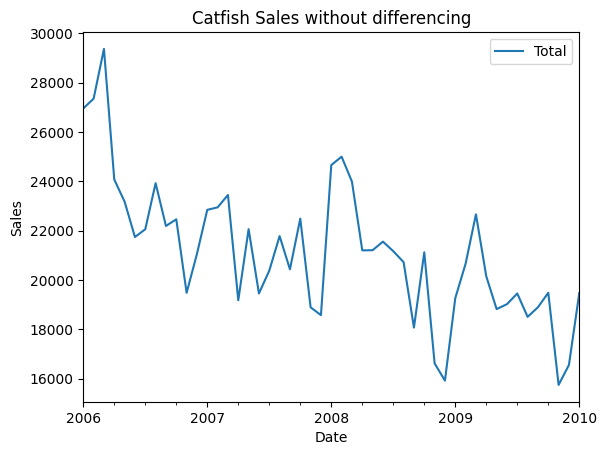

In [171]:
df.plot()
plt.ylabel("Sales")
plt.title("Catfish Sales without differencing")

In [172]:
df = df.dropna()

In [173]:
autocorr = df['Total'].autocorr()
print(f"The autocorrelation value is: {autocorr}")

The autocorrelation value is: 0.6643494244683742


### Checking if the data has stationarity using augmented dickey fuller test

In [174]:
adf_val = adfuller(df['Total'])
print(f"Test statistic is: {adf_val[0]}\nThe p-value is: {adf_val[1]}")

Test statistic is: -1.2750894241813466
The p-value is: 0.6404904933707772


#### Note that the p-value is high, so we can't reject the null hypothesis: The data is non-stationary.
#### We need to apply differencing
#### Let's see what would be a good model by applying the ACF and PACF

In [175]:
first_diff = df.diff()[1:]

Text(0.5, 1.0, 'First difference of Cat Fish sales')

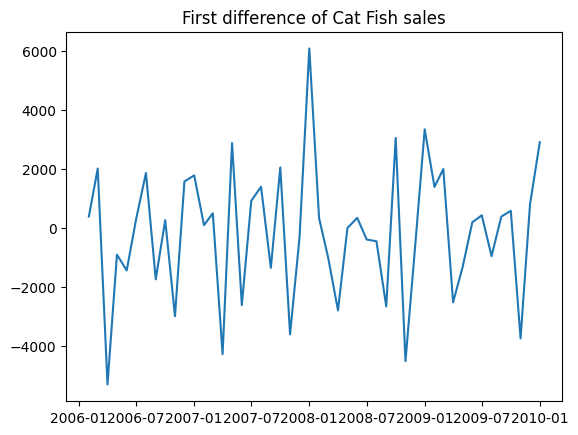

In [176]:
plt.plot(first_diff)
plt.title("First difference of Cat Fish sales")

In [177]:
adf_first_diff = adfuller(first_diff)
print(f"Test statistic:{adf_first_diff[0]}\np-value: {adf_first_diff[1]}")

Test statistic:-4.750384090254694
p-value: 6.760516182780776e-05


In [178]:
#Now the series is stationary as we can reject null hypothesis (p-value is low at 0.004)

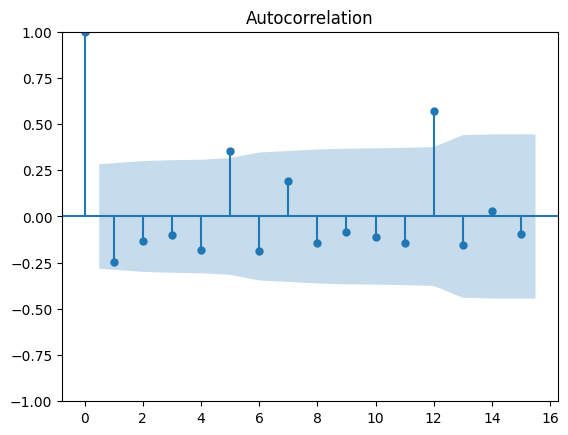

In [179]:
acf_plot = plot_acf(first_diff, lags = 15, alpha = 0.05)

In [180]:
#Based on the acf, we should start a MA(1) process as the lag one has a high value

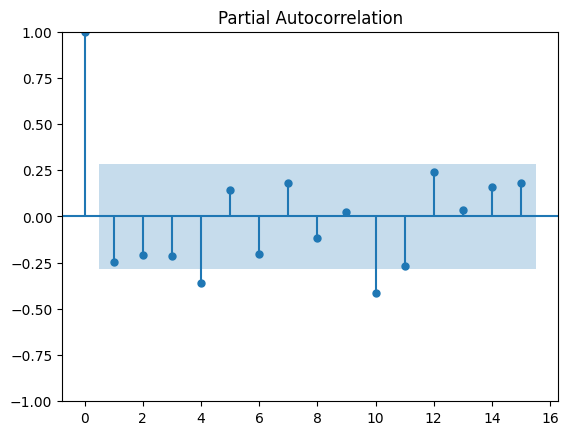

In [181]:
pacf_plot  = plot_pacf(first_diff, lags = 15, alpha = 0.05)

In [182]:
#From the ACF and PACF, let's go with a ARMA(4,1) model with MA(1) and AR(4)

In [183]:
#Training and testing split

In [184]:
train_end = datetime(2009,1,1)
test_end = datetime(2010,1,1)

In [185]:
train_split = df[:train_end]
test_split = df[train_end + timedelta(days = 1):test_end]

### Fitting the ARIMA model order = (4,0,1)

In [192]:
model = ARIMA(train_split, order=(4,0,4)).fit()
model.summary()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   37
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -333.634
Date:                Fri, 22 Nov 2024   AIC                            687.267
Time:                        01:03:49   BIC                            703.377
Sample:                    01-01-2006   HQIC                           692.947
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.18e+04   1929.053     11.303      0.000     1.8e+04    2.56e+04
ar.L1          1.0211      0.301      3.392      0.001       0.431       1.611
ar.L2         -0.2358      0.482     -0.489      0.625      -1.180       0.709
ar.L3         -0.7419      0.576     -1.288      0.198      -1.871       0.387
ar.L4          0.7876      0.248      3.170      0.002       0.301       1.275
ma.L1         -0.4417      1.047     -0.422      0.673      -2.493       1.610
ma.L2          0.0039      1.648      0.002      0.998      -3.227       3.235
ma.L3          0.9433      0.767      1.230      0.219      -0.560       2.447
ma.L4         -0.4988      0.544     -0.918      0.359      -1.564       0.567
sigma2      4.145e+06      0.046   9.04e+07      0.000    4.15e+06    4.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.61   Prob(JB):                         0.41
Heteroskedasticity (H):               0.93   Skew:                             0.50
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.05e+24. Standard errors may be unstable.
"""

#### Only ar.L1 (Lag 1 of AR term) and ma.L1 (Lag 1 of MA term) are statistically significant. Hence, let's use order = (1,0,1)

In [196]:
model1 = ARIMA(train_split, order = (1,0,1)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   37
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -337.060
Date:                Fri, 22 Nov 2024   AIC                            682.120
Time:                        01:04:24   BIC                            688.564
Sample:                    01-01-2006   HQIC                           684.392
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.181e+04   1024.594     21.287      0.000    1.98e+04    2.38e+04
ar.L1          0.7545      0.207      3.643      0.000       0.349       1.160
ma.L1         -0.1820      0.362     -0.503      0.615      -0.891       0.527
sigma2      4.714e+06   1.34e+06      3.508      0.000    2.08e+06    7.35e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.82   Prob(JB):                         0.83
Heteroskedasticity (H):               0.89   Skew:                             0.15
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [188]:
pred_start_date = test_split.index[0]
pred_end_date = test_split.index[-1]

In [199]:
predictions_1 = model1.predict(start = pred_start_date, end = pred_end_date)
residuals_1 = test_split['Total'] - predictions_1 

In [193]:
predictions = model.predict(start = pred_start_date, end = pred_end_date)
residuals = test_split['Total'] - predictions

Text(0, 0.5, 'Error')

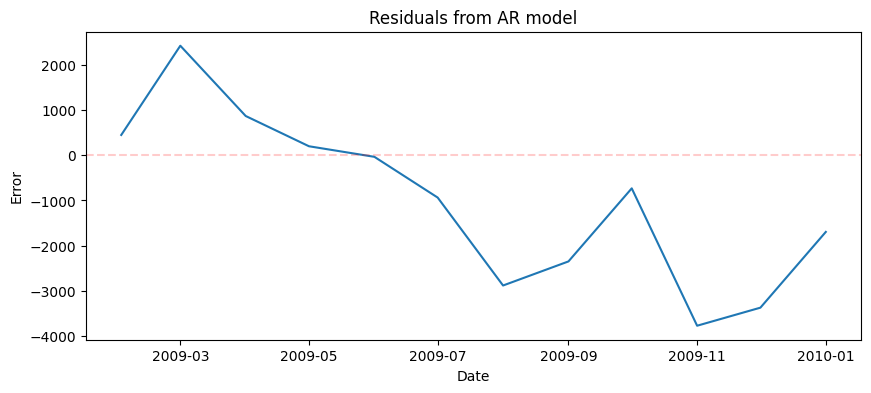

In [194]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.title("Residuals from AR model")
plt.xlabel("Date")
plt.ylabel("Error")

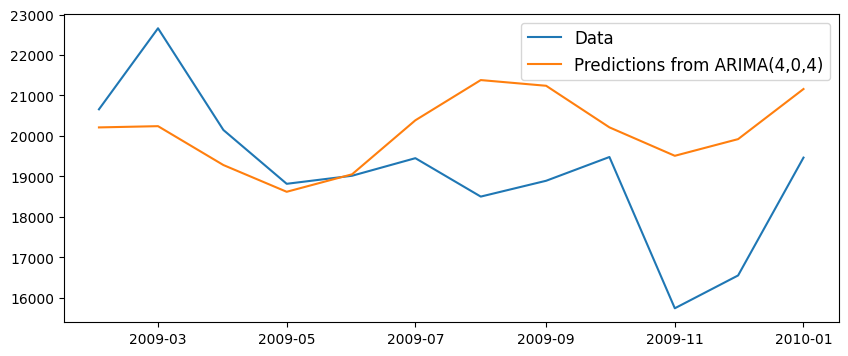

In [198]:
plt.figure(figsize=(10,4))
plt.plot(test_split)
plt.plot(predictions)

plt.legend(("Data", "Predictions from ARIMA(4,0,4)"), fontsize = 12)

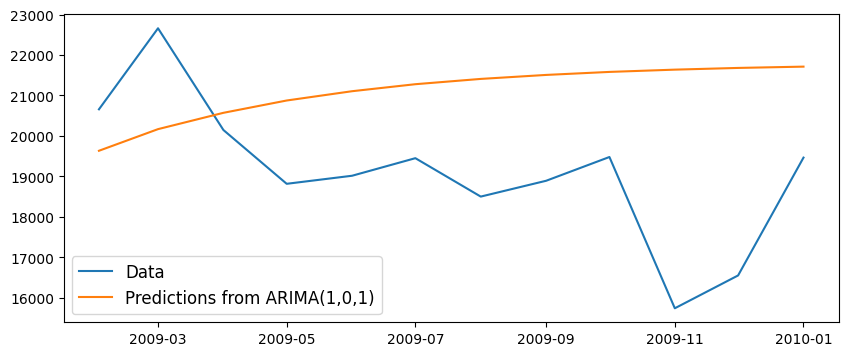

In [200]:
plt.figure(figsize=(10,4))
plt.plot(test_split)
plt.plot(predictions_1)

plt.legend(("Data", "Predictions from ARIMA(1,0,1)"), fontsize = 12)